<a href="https://colab.research.google.com/github/Jaykumar-coder/searce/blob/main/asgn2_churn_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import time

In [2]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


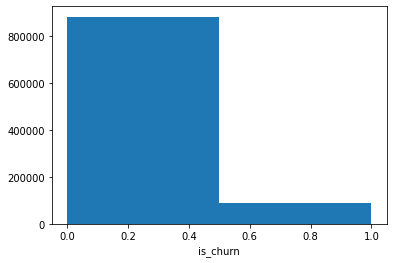

In [3]:
# Importing the data from the csv files (File path may be varied accordingly)
train_df=pd.read_csv('/content/drive/MyDrive/searce/train_v2.csv')
transaction_df=pd.read_csv('/content/drive/MyDrive/searce/transactions_v2.csv')
members_df=pd.read_csv('/content/drive/MyDrive/searce/members_v3.csv')
userlogs_df=pd.read_csv('/content/drive/MyDrive/searce/user_logs_v2.csv')

plt.hist(train_df['is_churn'], bins = [0,0.5,1])
plt.xlabel('is_churn')
plt.show()

Here, we can see  that the data is imbalanced, thus we are required to take approximately equal no of both classes to train better model.
downsizing of data is also required to reduce the computation time as the data is large.

In [4]:
# Random sampling of the train_df data for each of the labels for target variable
train_df_0=train_df.loc[train_df['is_churn'] == 0].sample(n=2000)
train_df_1=train_df.loc[train_df['is_churn'] == 1].sample(n=2000)
train_df = pd.concat([train_df_0, train_df_1])

In [5]:
# Merging all the different datasets to obtain a combined dataset
data = pd.merge(train_df, transaction_df, on='msno', how='left')
data = pd.merge(data, members_df, on='msno', how='left')
data = pd.merge(data, userlogs_df, on='msno', how='left')
display(data)

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,city,bd,gender,registered_via,registration_init_time,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,xcGe2DV/qcCmRmA+l6z5M7XlwK+iPAFq9kmEdOURsOQ=,0,30.0,30.0,100.0,100.0,1.0,20170304.0,20170403.0,0.0,1.0,0.0,NaN,13.0,20170103.0,20170305.0,1.0,0.0,0.0,0.0,25.0,24.0,6129.875
1,xcGe2DV/qcCmRmA+l6z5M7XlwK+iPAFq9kmEdOURsOQ=,0,30.0,30.0,100.0,100.0,1.0,20170304.0,20170403.0,0.0,1.0,0.0,NaN,13.0,20170103.0,20170317.0,1.0,2.0,1.0,0.0,4.0,5.0,1342.658
2,xcGe2DV/qcCmRmA+l6z5M7XlwK+iPAFq9kmEdOURsOQ=,0,30.0,30.0,100.0,100.0,1.0,20170304.0,20170403.0,0.0,1.0,0.0,NaN,13.0,20170103.0,20170325.0,8.0,2.0,0.0,0.0,28.0,34.0,7314.300
3,xcGe2DV/qcCmRmA+l6z5M7XlwK+iPAFq9kmEdOURsOQ=,0,30.0,30.0,100.0,100.0,1.0,20170304.0,20170403.0,0.0,1.0,0.0,NaN,13.0,20170103.0,20170308.0,1.0,0.0,0.0,0.0,2.0,3.0,530.128
4,xcGe2DV/qcCmRmA+l6z5M7XlwK+iPAFq9kmEdOURsOQ=,0,30.0,30.0,100.0,100.0,1.0,20170304.0,20170403.0,0.0,1.0,0.0,NaN,13.0,20170103.0,20170310.0,1.0,1.0,1.0,0.0,3.0,6.0,1015.294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,/1nQE3nfqUSJzlJxZM4eLv8zDMarxe8rqveT8TRm/fU=,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,3.0,20130209.0,20170307.0,2.0,0.0,2.0,3.0,15.0,16.0,4779.630
72979,/1nQE3nfqUSJzlJxZM4eLv8zDMarxe8rqveT8TRm/fU=,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,3.0,20130209.0,20170301.0,5.0,2.0,0.0,2.0,0.0,8.0,593.267
72980,/1nQE3nfqUSJzlJxZM4eLv8zDMarxe8rqveT8TRm/fU=,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,3.0,20130209.0,20170304.0,25.0,24.0,8.0,15.0,45.0,79.0,18248.452
72981,w2gO5DKettlwOY6Uz0Ku0p4y/0VTC4oYu3dPj8JrqrQ=,1,41.0,30.0,129.0,129.0,1.0,20170306.0,20170307.0,1.0,1.0,0.0,NaN,7.0,20100405.0,20170325.0,0.0,0.0,0.0,0.0,1.0,1.0,297.168


now all the data are combined based on mnso.Now lets check the distribution of the updated down sampling data


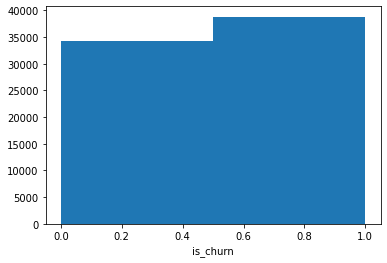

In [6]:
# Studying the variation of the labels now
plt.hist(data['is_churn'], bins = [0,0.5,1])
plt.xlabel('is_churn')
plt.show()

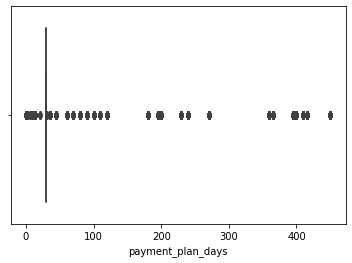

In [11]:
#lets check distribution of data plan
sns.boxplot(x='payment_plan_days', data=transaction_df)


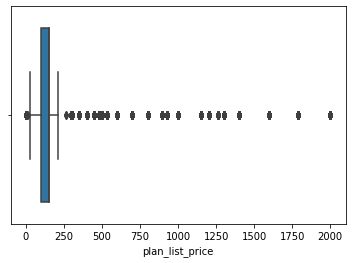

In [12]:
#lets check distribution of plan price
sns.boxplot(x='plan_list_price', data=transaction_df)

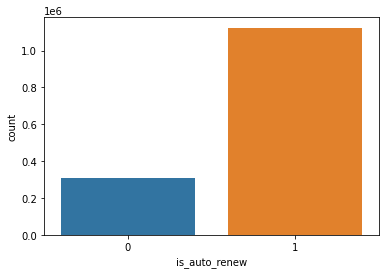

In [14]:
#check for auto renew distribution
sns.countplot(x='is_auto_renew', data=transaction_df)

In [13]:
#check for null values
data.isnull().sum()

msno                          0
is_churn                      0
payment_method_id          5137
payment_plan_days          5137
plan_list_price            5137
actual_amount_paid         5137
is_auto_renew              5137
transaction_date           5137
membership_expire_date     5137
is_cancel                  5137
city                        505
bd                          505
gender                    28963
registered_via              505
registration_init_time      505
date                       1411
num_25                     1411
num_50                     1411
num_75                     1411
num_985                    1411
num_100                    1411
num_unq                    1411
total_secs                 1411
dtype: int64

Its seems that there are lot of null values and hence a preprocessing is required.

#### Data Pre-processing

In [16]:
# A function that takes care of all the null values and unwanted columns in the dataset
# Returns two seperate dataframes X (feature vectors) and Y (labels)
def process(data):
  # Substituting 0 for blank payment_method_id
  data['payment_method_id'] = data['payment_method_id'].fillna(0)

  # Removing outliers
  data['payment_plan_days'] = data['payment_plan_days'].apply(lambda x: x if (x <= 30.0) else np.nan)
  # Set the default payment_plan_days to 30 days
  data['payment_plan_days'] = data['payment_plan_days'].fillna(30.0)

  # Removing outliers
  data['plan_list_price'] = data['plan_list_price'].apply(lambda x: x if (x <= 180.0) else np.nan)
  # Set the default plan_list_price to 149
  data['plan_list_price'] = data['plan_list_price'].fillna(149.0)

  # Removing outliers
  data['actual_amount_paid'] = data['actual_amount_paid'].apply(lambda x: x if (x <= 180.0) else np.nan)
  # imputing the default actual_amount_paid to 149.0
  data['actual_amount_paid'] = data['actual_amount_paid'].fillna(149.0)

  # Set the default is_auto_renew to 2
  data['is_auto_renew'] = data['is_auto_renew'].fillna(2)

  # Set the default for is_cancel to 2
  data['is_cancel'] = data['is_cancel'].fillna(2)

  # Set the default for city to 0
  data['city'] = data['city'].fillna(0)

  # Eliminating the outliers and considering only age 0-70
  data['bd'] = data['bd'].apply(lambda x: x if (x < 70.0) and (x > 0.0) else np.nan)
  data['bd'] = data['bd'].fillna(28.0)

  # Processing the genders as 0:NaN, 1:Male, 2:Female
  data['gender'] = data['gender'].fillna(0)
  data['gender'] = data['gender'].replace(to_replace='male', value=1)
  data['gender'] = data['gender'].replace(to_replace='female', value=2)

  # Setting median date in place of nan in the df
  data['registration_init_time'] = data['registration_init_time'].fillna(20150204.0)
  # Getting registration_init_time array and store to registration_time list
  registration_time = data['registration_init_time'].values

  # Set the default for registered_via to 0
  data['registered_via'] = data['registered_via'].fillna(0)

  # Removing outliers
  data['num_25'] = data['num_25'].apply(lambda x: x if (x <= 15.0) else np.nan)
  # Set the default num_25 to 2
  data['num_25'] = data['num_25'].fillna(2.0)

  # Removing outliers
  data['num_50'] = data['num_50'].apply(lambda x: x if (x <= 4.0) else np.nan)
  # Set the default num_50 to 0
  data['num_50'] = data['num_50'].fillna(0)

  # Removing outliers
  data['num_75'] = data['num_75'].apply(lambda x: x if (x <= 3.0) else np.nan)
  # Set the default num_75 to 0
  data['num_75'] = data['num_75'].fillna(0)

  # Removing outliers
  data['num_985'] = data['num_985'].apply(lambda x: x if (x <= 3.0) else np.nan)
  # Set the default num_985 to 0
  data['num_985'] = data['num_985'].fillna(0)

  # Removing outliers
  data['num_100'] = data['num_100'].apply(lambda x: x if (x <= 74.0) else np.nan)
  # Set the default num_100 to 14
  data['num_100'] = data['num_100'].fillna(14.0)

  # Removing outliers
  data['num_unq'] = data['num_unq'].apply(lambda x: x if (x <= 68.0) else np.nan)
  # Set the default num_unq to 16
  data['num_unq'] = data['num_unq'].fillna(16.0)

  # Removing outliers
  data['total_secs'] = data['total_secs'].apply(lambda x: x if (x <= 18000) else np.nan)
  # Set the default total_secs to 2
  data['total_secs'] = data['total_secs'].fillna(3900)

  X = data
  X = X.drop(['is_churn', 'msno', 'transaction_date', 'membership_expire_date', 'date'], axis=1)
  Y = data['is_churn']

  return X, Y

In [17]:
X, Y = process(data)
display(X)

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,bd,gender,registered_via,registration_init_time,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,30.0,30.0,100.0,100.0,1.0,0.0,1.0,28.0,0,13.0,20170103.0,1.0,0.0,0.0,0.0,25.0,24.0,6129.875
1,30.0,30.0,100.0,100.0,1.0,0.0,1.0,28.0,0,13.0,20170103.0,1.0,2.0,1.0,0.0,4.0,5.0,1342.658
2,30.0,30.0,100.0,100.0,1.0,0.0,1.0,28.0,0,13.0,20170103.0,8.0,2.0,0.0,0.0,28.0,34.0,7314.300
3,30.0,30.0,100.0,100.0,1.0,0.0,1.0,28.0,0,13.0,20170103.0,1.0,0.0,0.0,0.0,2.0,3.0,530.128
4,30.0,30.0,100.0,100.0,1.0,0.0,1.0,28.0,0,13.0,20170103.0,1.0,1.0,1.0,0.0,3.0,6.0,1015.294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,0.0,30.0,149.0,149.0,2.0,2.0,1.0,28.0,0,3.0,20130209.0,2.0,0.0,2.0,3.0,15.0,16.0,4779.630
72979,0.0,30.0,149.0,149.0,2.0,2.0,1.0,28.0,0,3.0,20130209.0,5.0,2.0,0.0,2.0,0.0,8.0,593.267
72980,0.0,30.0,149.0,149.0,2.0,2.0,1.0,28.0,0,3.0,20130209.0,2.0,0.0,0.0,0.0,45.0,16.0,3900.000
72981,41.0,30.0,129.0,129.0,1.0,1.0,1.0,28.0,0,7.0,20100405.0,0.0,0.0,0.0,0.0,1.0,1.0,297.168


In [18]:
#now again lets check for null data
data.isnull().sum()

msno                         0
is_churn                     0
payment_method_id            0
payment_plan_days            0
plan_list_price              0
actual_amount_paid           0
is_auto_renew                0
transaction_date          5137
membership_expire_date    5137
is_cancel                    0
city                         0
bd                           0
gender                       0
registered_via               0
registration_init_time       0
date                      1411
num_25                       0
num_50                       0
num_75                       0
num_985                      0
num_100                      0
num_unq                      0
total_secs                   0
dtype: int64

The rest null value column are not important for the futher analysis and can be dropped.


#### Principal Component Analysis

In [19]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X.to_numpy())

print("Variance retained: %s" % (sum(pca.explained_variance_ratio_)))

Variance retained: 0.9999999842087076


We reduce the dimensionality of the feature vectors from 18 to 10 to reduce the irrelevant information, and yet we can see that we 99.99999% of the variance is still retained thus depicting very minute fraction of information being lost.

#### Pre-processing the data for ML model

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, Y, test_size=0.4, random_state=57)
display(X_train)

array([[-2.22332137e+04,  4.73881919e+02, -2.27224789e+01, ...,
        -8.32592600e+00,  5.86612092e+00, -2.03700879e+00],
       [-1.62323226e+03,  1.86920583e+02, -1.74646279e+01, ...,
         3.45364980e+00, -5.09071951e+00,  3.50638824e-01],
       [ 2.80896827e+04, -1.35650546e+03, -5.52232170e+01, ...,
         4.88490089e+00, -3.63034224e+00,  1.22553720e+00],
       ...,
       [-2.13083278e+04, -1.11257575e+03,  4.81262627e+01, ...,
         3.15871541e+00, -3.38116453e+00, -7.35538978e-01],
       [ 1.83940913e+04,  5.58539798e+03,  1.74724130e+01, ...,
         3.26634615e+00, -6.57998958e+00,  4.70537777e-01],
       [-3.12149987e+04,  3.82801635e+03, -6.67558376e+01, ...,
         4.50469408e+00, -3.72964289e+00, -8.03080652e-01]])

In [21]:
scaler= preprocessing.StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))
display(X_train)
X_val=pd.DataFrame(scaler.transform(X_val))

,0,1,2,3,4,5,6,7,8,9
0,-0.753658,0.116532,-0.482765,-0.418048,0.609963,-0.005694,0.285172,-1.313626,0.967614,-0.610861
1,-0.053242,0.045325,-0.372211,-0.505098,-0.632531,-0.000637,0.088327,0.537680,-0.840057,0.106703
2,0.956532,-0.337662,-1.166139,-0.007541,-0.264675,0.048414,-0.031254,0.762619,-0.599122,0.369638
3,-0.043052,-0.579614,-0.399635,0.478481,-0.432710,0.017224,-0.620464,-1.064064,0.713321,1.136393
4,-1.096741,-1.144991,-0.561217,-0.400546,-0.468826,0.001836,-0.238616,0.575168,-0.399509,0.324134
...,...,...,...,...,...,...,...,...,...,...
43784,-1.075670,-1.027268,0.041530,-0.527552,-0.662544,-0.042913,-0.052296,0.474677,-0.353742,-0.243414
43785,-0.059676,-1.227154,1.069784,-0.465218,-0.479485,-0.158235,-0.096743,0.335139,-0.676920,0.087063
43786,-0.722227,-0.277133,1.006929,-0.191586,-0.565961,-0.158490,-0.148756,0.491327,-0.558013,-0.219728
43787,0.627034,1.384907,0.362389,-0.541978,-0.504906,-0.080743,0.380913,0.508243,-1.085758,0.142737


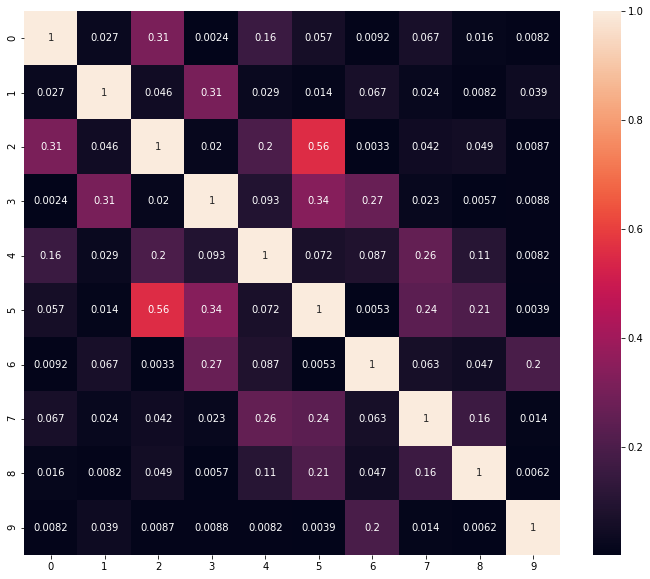

In [22]:
corrMatrix = X_train.corr(method='spearman')
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(abs(corrMatrix), annot=True)
plt.show()

The correlation matrix here does show that all the features are very much independent of each other.

#### Building an ML model: Random Forest Classifier

In [23]:
start_time=time.time()
scoring = 'f1'
rfc = RandomForestClassifier()
hyperparameters = {'max_depth':[2,5,10,20],'n_estimators':[10,30,100]}
clf = GridSearchCV(rfc, param_grid=hyperparameters, scoring='f1')
clf.fit(np.array(X_train), np.squeeze(y_train))
print('Training time for Random Forest Classifier: %.2f seconds \n'%(time.time()-start_time))
print('Best parameters: ')
print(clf.best_params_)
print('Best' +scoring+":" +str(clf.best_score_))

print('Test classification report:')
y_true, y_pred = np.squeeze(y_val), clf.predict(np.array(X_val))
print(classification_report(y_true, y_pred))

print('Test AUC-ROC: '+str(roc_auc_score(y_true, y_pred)))

Training time for Random Forest Classifier: 224.43 seconds 

Best parameters: 
{'max_depth': 20, 'n_estimators': 100}
Bestf1:0.943471959675346
Test classification report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     13695
           1       0.97      0.94      0.95     15499

    accuracy                           0.95     29194
   macro avg       0.95      0.95      0.95     29194
weighted avg       0.95      0.95      0.95     29194

Test AUC-ROC: 0.9500494785127995


Building a model On XG Boost


In [33]:
import xgboost as xgb
from xgboost import XGBClassifier


In [32]:
start_time=time.time()
scoring = 'f1'
xgb =  XGBClassifier()
hyperparameters = {'max_depth':[2,5,10,20],'n_estimators':[10,30,100]}
clf = GridSearchCV(xgb, param_grid=hyperparameters, scoring='f1')
clf.fit(np.array(X_train), np.squeeze(y_train))
print('Training time for XGBoost Classifier: %.2f seconds \n'%(time.time()-start_time))
print('Best parameters: ')
print(clf.best_params_)
print('Best' +scoring+":" +str(clf.best_score_))

print('Test classification report:')
y_true, y_pred = np.squeeze(y_val), clf.predict(np.array(X_val))
print(classification_report(y_true, y_pred))

print('Test AUC-ROC: '+str(roc_auc_score(y_true, y_pred)))

Training time for XGBoost Classifier: 295.55 seconds 

Best parameters: 
{'max_depth': 20, 'n_estimators': 100}
Bestf1:0.9735632567298321
Test classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     13695
           1       0.98      0.97      0.98     15499

    accuracy                           0.98     29194
   macro avg       0.98      0.98      0.98     29194
weighted avg       0.98      0.98      0.98     29194

Test AUC-ROC: 0.9782648498374426


#### Model evaluation

In order to further evaluate the model, we test it on a completely unseen test data.

In [24]:
test_df=train_df.sample(n=2000)

In [25]:
test = pd.merge(test_df, transaction_df, on='msno', how='left')
test = pd.merge(test, members_df, on='msno', how='left')
test = pd.merge(test, userlogs_df, on='msno', how='left')
display(test)

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,city,bd,gender,registered_via,registration_init_time,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,x8cI6+dUiWVx9HiY6vwTx6kZjgQnYKIFTyzErrTzMZ0=,0,41.0,30.0,149.0,149.0,1.0,20170321.0,20170421.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ep/nPEw5R+KTQCWtRQTHU3kc3HFEwN6eYoOkmReCQEE=,0,36.0,30.0,180.0,180.0,1.0,20170316.0,20170419.0,0.0,1.0,0.0,NaN,4.0,20161113.0,20170314.0,0.0,0.0,0.0,0.0,2.0,2.0,427.362
2,Ep/nPEw5R+KTQCWtRQTHU3kc3HFEwN6eYoOkmReCQEE=,0,36.0,30.0,180.0,180.0,1.0,20170316.0,20170419.0,0.0,1.0,0.0,NaN,4.0,20161113.0,20170307.0,4.0,3.0,2.0,1.0,2.0,10.0,1200.821
3,Ep/nPEw5R+KTQCWtRQTHU3kc3HFEwN6eYoOkmReCQEE=,0,36.0,30.0,180.0,180.0,1.0,20170316.0,20170419.0,0.0,1.0,0.0,NaN,4.0,20161113.0,20170316.0,5.0,0.0,0.0,2.0,0.0,7.0,444.238
4,Ep/nPEw5R+KTQCWtRQTHU3kc3HFEwN6eYoOkmReCQEE=,0,36.0,30.0,180.0,180.0,1.0,20170316.0,20170419.0,0.0,1.0,0.0,NaN,4.0,20161113.0,20170311.0,1.0,0.0,1.0,0.0,28.0,29.0,6920.583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35297,BAb8HUM/kTXwnAZ3gtODmZWPXE8/KonDToVZ1CMawJQ=,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,NaN,3.0,20130411.0,20170306.0,25.0,1.0,0.0,0.0,6.0,32.0,1638.150
35298,BAb8HUM/kTXwnAZ3gtODmZWPXE8/KonDToVZ1CMawJQ=,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,NaN,3.0,20130411.0,20170316.0,16.0,3.0,1.0,1.0,7.0,28.0,2526.224
35299,BAb8HUM/kTXwnAZ3gtODmZWPXE8/KonDToVZ1CMawJQ=,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,NaN,3.0,20130411.0,20170309.0,35.0,1.0,0.0,1.0,7.0,41.0,2061.623
35300,BAb8HUM/kTXwnAZ3gtODmZWPXE8/KonDToVZ1CMawJQ=,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,NaN,3.0,20130411.0,20170304.0,2.0,0.0,2.0,1.0,5.0,8.0,1875.583


In [26]:
# Processing the data to take care of null values and unwanted columns
X_test, y_test = process(test)

# PCA Fitting
X_test_pca = pca.fit_transform(X_test.to_numpy())

# Standardising the X_test data
X_test=pd.DataFrame(scaler.transform(X_test_pca))

In [27]:
start_time = time.time()
y_true, y_pred = np.squeeze(y_test), clf.predict(np.array(X_test))
print('Testing time: %.2f seconds \n'%(time.time()-start_time))

print('Test classification report:')
print(classification_report(y_true, y_pred))

print('Test AUC-ROC: '+str(roc_auc_score(y_true, y_pred)))

Testing time: 0.46 seconds 

Test classification report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62     16246
           1       0.68      0.68      0.68     19056

    accuracy                           0.65     35302
   macro avg       0.65      0.65      0.65     35302
weighted avg       0.65      0.65      0.65     35302

Test AUC-ROC: 0.6517105082405868


The accuracy on the model is 80% on this test dataset,which can be considered good.

The test prediction on Xgboost classifier 

In [34]:
start_time = time.time()
y_true, y_pred = np.squeeze(y_test), clf.predict(np.array(X_test))
print('Testing time: %.2f seconds \n'%(time.time()-start_time))

print('Test classification report:')
print(classification_report(y_true, y_pred))

print('Test AUC-ROC: '+str(roc_auc_score(y_true, y_pred)))

Testing time: 0.65 seconds 

Test classification report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.62     16246
           1       0.68      0.70      0.69     19056

    accuracy                           0.66     35302
   macro avg       0.66      0.66      0.66     35302
weighted avg       0.66      0.66      0.66     35302

Test AUC-ROC: 0.655805306154028


The xgboost perform better fit to the model even though there is down sizing of the data.